In [1]:
import os
from datetime import datetime
from hashlib import sha256

import pandas as pd
import numpy as np

# -------------------------
# model libs
from pycaret.classification import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from nimbusml.ensemble import LightGbmClassifier # Módulo de ML da Microsoft
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

# -------------------------
# model validation and hyperparameter tunning libs
from sklearn.model_selection import (cross_val_score, RepeatedStratifiedKFold,
                                     RandomizedSearchCV, GridSearchCV, train_test_split)

from sklearn.metrics import (precision_recall_curve, average_precision_score, classification_report)

# -------------------------
# graph libs
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib

os.chdir("../src/")
from utils.data_describe import DataDescribe as dd
from utils.classification_model_evaluation import ClassificationModelEvaluation as cme

basepath = "../data/external/"
path_x_train = "../data/external/train_values.csv"
path_y_train = "../data/external/train_labels.csv"
path_x_test = "../data/external/test_values.csv"

path_x_selected = "../data/interim/"
path_processed = "../data/processed/"
path_model = "../models/"

In [30]:
# List all files in a directory using scandir()
print("-"*30)
print(f"Arquivos em {path_processed}:\n")

with os.scandir(path_processed) as entries:
    for entry in entries:
        if entry.is_file() and (("csv" in entry.name) or ("pqt" in entry.name)):
            print(entry.name)

print("-"*30)

------------------------------
Arquivos em ../data/processed/:

df_train.pqt
X_test_encoded.csv
X_test_encoded.pqt
y_test.csv
model_evaluation.csv
------------------------------


# Carregando dataframe da preparação de dados

In [31]:
df_train = pd.read_parquet(path_processed+"df_train.pqt")
print(f"Dimensão do dataset de treinamento: {df_train.shape}.")
df_train.head()

Dimensão do dataset de treinamento: (260601, 61).


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_t,land_surface_condition_o,roof_type_n,roof_type_q,legal_ownership_status_v,legal_ownership_status_a,legal_ownership_status_r,other_floor_type_q,other_floor_type_x,other_floor_type_j,position_t,position_s,position_j,foundation_type_r,foundation_type_w,foundation_type_i,foundation_type_u,ground_floor_type_f,ground_floor_type_x,ground_floor_type_v,ground_floor_type_z,plan_configuration_d,plan_configuration_u,plan_configuration_s,plan_configuration_q,plan_configuration_m,plan_configuration_c,plan_configuration_a,plan_configuration_n,plan_configuration_f,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,-0.983414,-0.518705,1.629055,-0.178274,0.047100,-0.459460,-0.226419,3.206391,0.558971,-0.188554,-0.136284,-0.270442,-0.285298,-0.585029,-0.304811,-0.210914,-0.126945,-0.123339,0.038365,-0.354928,-0.262312,-0.186537,-0.09037,-0.030676,-0.018996,-0.032738,-0.013714,-0.012076,-0.009395,-0.071731,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,3
28830,-0.734459,0.481998,-0.945017,-0.178274,-0.224765,-0.004110,0.816109,-0.311877,0.558971,-0.188554,-0.136284,-0.270442,-0.285298,-0.585029,-0.304811,-0.210914,-0.126945,-0.123339,0.038365,-0.354928,-0.262312,-0.186537,-0.09037,-0.030676,-0.018996,-0.032738,-0.013714,-0.012076,-0.009395,-0.071731,0,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2
94947,0.883744,-0.819158,0.744612,-0.178274,-0.224765,-0.687135,-0.226419,-0.311877,0.558971,-0.188554,-0.136284,-0.270442,-0.285298,-0.585029,-0.304811,-0.210914,-0.126945,-0.123339,0.038365,-0.354928,-0.262312,-0.186537,-0.09037,-0.030676,-0.018996,-0.032738,-0.013714,-0.012076,-0.009395,-0.071731,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,3
590882,1.008221,-0.685893,1.216589,-0.178274,-0.224765,-0.459460,-0.226419,-0.311877,0.558971,-0.188554,-0.136284,-0.270442,-0.285298,1.709316,3.280725,-0.210914,-0.126945,-0.123339,0.038365,-0.354928,-0.262312,-0.186537,-0.09037,-0.030676,-0.018996,-0.032738,-0.013714,-0.012076,-0.009395,-0.071731,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,2
201944,-0.361028,-1.381296,-1.308119,1.195989,0.047100,-0.004110,1.858636,3.206391,-1.789003,-0.188554,-0.136284,-0.270442,-0.285298,-0.585029,-0.304811,-0.210914,-0.126945,-0.123339,0.038365,-0.354928,-0.262312,-0.186537,-0.09037,-0.030676,-0.018996,-0.032738,-0.013714,-0.012076,-0.009395,-0.071731,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,3


# Testando modelos

Nessa parte, estou usando a biblioteca [PyCaret](https://pycaret.org/) para avaliar vários modelos para esse problema de classificação múltipla. Depois dessa avaliação inicial, pegaremos um ou alguns dos modelos para seguir em frente (fazer tunning dos hiperparâmetros e testar com sets diferentes de dados obtidos após seleção de variáveis).

In [32]:
clf1 = setup(data = df_train, target = "damage_grade")
best = compare_models(sort = 'F1')

INFO:logs:PyCaret Classification Module
INFO:logs:version 2.1.2
INFO:logs:Initializing setup()
INFO:logs:USI: 0668
INFO:logs:setup(data=(260601, 61), target=damage_grade, train_size=0.7, sampling=True, sample_estimator=None, categorical_features=None, categorical_imputation=constant, ordinal_features=None,
                    high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, date_features=None, ignore_features=None, normalize=False,
                    normalize_method=zscore, transformation=False, transformation_method=yeo-johnson, handle_unknown_categorical=True, unknown_categorical_method=least_frequent, pca=False, pca_method=linear,
                    pca_components=None, ignore_low_variance=False, combine_rare_levels=False, rare_level_threshold=0.1, bin_numeric_features=None, remove_outliers=False, outliers_threshold=0.05,
                    remove_multicollinearity=False, multicollinearity_threshold=0.9, remove_pe

IntProgress(value=0, description='Processing: ', max=13)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:12:32
Status,. . . . . . . . . . . . . . . . . .,Preparing Data for Modeling
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


INFO:logs:Importing libraries


INFO:logs:Declaring global variables
INFO:logs:Copying data for preprocessing
INFO:logs:Declaring preprocessing parameters
INFO:logs:Importing preprocessing module
INFO:logs:Creating preprocessing pipeline


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
geo_level_1_id,Numeric
geo_level_2_id,Numeric
geo_level_3_id,Numeric
count_floors_pre_eq,Numeric
age,Numeric
area_percentage,Numeric
height_percentage,Numeric
has_superstructure_adobe_mud,Categorical
has_superstructure_mud_mortar_stone,Categorical
has_superstructure_stone_flag,Categorical


quit


SystemExit: Read the documentation of setup to learn how to overwrite data types over the inferred types. setup function must run again before you continue modeling.

## Resultado da seleção

Na tabela acima (e abaixo, adicionei uma figura para não perdermos o primeiro resultado, nosso baseline), vemos que os modelos de boosting trees se sairam melhor nesse problema.
Gostaria de testar os seguintes modelos:

1. ~~[Extreme Gradient Boosting](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier) -> pois está em primeiro.~~ *veremos posteriormente, pois demora demais*
1. ~~[CatBoost Classifier](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) -> pois está em segundo.~~ *veremos posteriormente, pois demora demais*
1. [Light Gradient Boosting Machine](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html) -> pois está em terceiro.
1. ~~[SVM com kernel não linear](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) -> pois NÃO está na lista, apenas seu kernel linear.~~ *veremos posteriormente, pois demora demais*
1. [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#forest) -> pois roda rápido.

<img src="./images/3_modeling_models_comparation_v1.JPG" alt="Tabela com o comparativo dos modelos.">



### Extreme Gradient Boosting (XGBoost)

Para os modelos Extreme Gradient Boosting, CatBoost Classifier e Light Gradient Boosting, usamos (muito) o texto do grande Jason Brownlee do [Machine Learning Mastery](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/), além das respectivas documentações (links colocados anteriormente).

In [7]:
X = df_train.drop(["damage_grade"], axis=1)
y = df_train["damage_grade"]

n_splits = 3
n_repeats = 3
random_state = 42
scoring = "f1_micro"

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=random_state)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

In [8]:
# model_xgb = XGBClassifier()

# n_scores = cross_val_score(model_xgb, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

# print(f"F1-micro: média: {n_scores.mean():.3f}  desvio padrão: {n_scores.std():.3f}")

In [9]:
print("""F1-micro: 0.729 (0.002) <- Esse é o valor que obtivemos com o XGboost com:
        n_splits = 10
        n_repeats = 3""")

F1-micro: 0.729 (0.002) <- Esse é o valor que obtivemos com o XGboost com:
        n_splits = 10
        n_repeats = 3


### CatBoost Classifier

In [10]:
# model_catb = CatBoostClassifier(verbose=0, n_estimators=100)

# n_scores = cross_val_score(model_catb, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

# print(f"F1-micro: média: {n_scores.mean():.3f}  desvio padrão: {n_scores.std():.3f}")

### Light Gradient Boosting (LightGBM)

In [11]:
model_lgbm = LGBMClassifier()

n_scores = cross_val_score(model_lgbm, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

print(f"F1-micro: média: {n_scores.mean():.3f}  desvio padrão: {n_scores.std():.3f}")

F1-micro: média: 0.711  desvio padrão: 0.001


### SVM com kernel não linear

In [12]:
# model_svc = SVC(kernel='rbf', random_state=random_state)

# n_scores = cross_val_score(model_svc, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

# print(f"F1-micro: média: {n_scores.mean():.3f}  desvio padrão: {n_scores.std():.3f}")

### Random forest

In [13]:
model_rf = RandomForestClassifier(random_state=42)

n_scores = cross_val_score(model_rf, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

print(f"F1-micro: média: {n_scores.mean():.3f}  desvio padrão: {n_scores.std():.3f}")

F1-micro: média: 0.707  desvio padrão: 0.001


In [14]:
model_rf = RandomForestClassifier(random_state=42)

model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_validation)
y_pred_proba = model_rf.predict_proba(X_validation)

classification_report_dict = classification_report(y_validation, y_pred, output_dict=True)

In [15]:
result = cme.classification_metrics_in_dataframe(y_validation, y_pred, model_rf)

In [16]:
cme.save_model_metrics(result, path_processed=path_processed)

O registro Int64Index([-8748344916489328608], dtype='int64') foi salvo na base model_evaluation.csv.


,model,precision,recall,f1-score,support,accuracy,params,date
5000852473507659831,RandomForestClassifier,0.706899,0.655220,0.676186,52121,0.727499,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-14
4257942832718635178,RandomForestClassifier,0.704536,0.654066,0.674593,52121,0.726674,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-14
-8655539271847579339,RandomForestClassifier,0.705567,0.654502,0.675262,52121,0.726828,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
-1996576357580872594,RandomForestClassifier,0.706317,0.639666,0.665004,52121,0.720612,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
3938368398258681123,RandomForestClassifier,0.697547,0.630247,0.655558,52121,0.712726,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
-8748344916489328608,RandomForestClassifier,0.697547,0.630247,0.655558,52121,0.712726,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15


# Otimização de hiperparâmetros

## Tunning do Light Gradient Boosting

Inicialmente, faremos o tunning sobre o Light Gradient Boosting, pois é o que possui menor tempo de execução (para comparação, o Extreme Gradient Boosting levou 17x mais que o Light Gradient Boosting, cerca de 60 min contra 3,5 min do LightGBM).

In [17]:
# params = {"boosting_type":["gbdt", "dart", "goss"],
#           "learning_rate":[.001, .01, .1],
#           "n_estimators":[10,50,100,150]}

# grid_search = GridSearchCV(estimator=model_lgbm, param_grid=params,
#                            scoring=scoring,cv=5, n_jobs=-1)

# grid_search = grid_search.fit(X, y)
# grid_search.best_params_

In [18]:
# grid_search.score(X, y)

### Usando os valores de hiperparâmetros após otimização

In [19]:
# model_lgbm = LGBMClassifier(**grid_search.best_params_)

# n_scores = cross_val_score(model_lgbm, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

# print('F1-micro: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

## Tunning do Random Forest

In [20]:
n_features_half = int(len(X_train.columns)/2)

params = {"n_estimators":[50, 100, 150],
          "criterion":["entropy", "gini"],
          "max_features":["sqrt", "log2", n_features_half]}

grid_search = GridSearchCV(estimator=model_rf, param_grid=params,
                           scoring=scoring, cv=3, n_jobs=1)

grid_search = grid_search.fit(X_train, y_train)
grid_search.best_params_

{'criterion': 'gini', 'max_features': 30, 'n_estimators': 150}

### Avaliando o modelo

In [21]:
# grid_search.best_params_
print(grid_search.best_params_)

{'criterion': 'gini', 'max_features': 30, 'n_estimators': 150}


In [24]:
model_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_validation)
y_pred_proba = model_rf.predict_proba(X_validation)

result = cme.classification_metrics_in_dataframe(y_validation, y_pred, model_rf)

result

,model,precision,recall,f1-score,support,accuracy,params,date
-6796991533066732651,RandomForestClassifier,0.703492,0.651143,0.672256,52121,0.725677,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-16


In [25]:
cme.save_model_metrics(result, path_processed=path_processed)

O registro -6796991533066732651 já foi salvo anteriormente no dia 2020-09-16.


,model,precision,recall,f1-score,support,accuracy,params,date
5000852473507659831,RandomForestClassifier,0.706899,0.655220,0.676186,52121,0.727499,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-14
4257942832718635178,RandomForestClassifier,0.704536,0.654066,0.674593,52121,0.726674,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-14
-8655539271847579339,RandomForestClassifier,0.705567,0.654502,0.675262,52121,0.726828,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
-1996576357580872594,RandomForestClassifier,0.706317,0.639666,0.665004,52121,0.720612,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
3938368398258681123,RandomForestClassifier,0.697547,0.630247,0.655558,52121,0.712726,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
-8748344916489328608,RandomForestClassifier,0.697547,0.630247,0.655558,52121,0.712726,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-15
-6796991533066732651,RandomForestClassifier,0.703492,0.651143,0.672256,52121,0.725677,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",2020-09-16


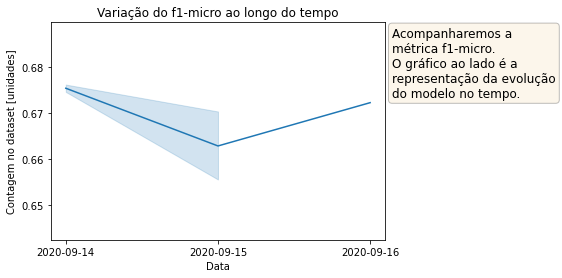

In [27]:
df_result = pd.read_csv(path_processed+"model_evaluation.csv", index_col=0)
df_result_graph = df_result[['precision', 'recall', 'f1-score', 'accuracy','date']]

# ---------------------------
# Gráfico--------------------
sns.axes_style("ticks")
ax = sns.lineplot(x='date', y='f1-score', data=df_result_graph)

y = df_result_graph["f1-score"]

y_max = y.max()*1.02
y_min = y.min()*.98
ax.set(ylim=(y_min, y_max))
ax.set(title="Variação do f1-micro ao longo do tempo", xlabel="Data", ylabel="Contagem no dataset [unidades]")

for p, label in zip(ax.patches, y.sort_index()):
    ax.annotate(str(label), (p.get_x()+.25, p.get_height()+.1), fontsize=12, color='black', ha='left', va='bottom')
    
textstr = f"""Acompanharemos a
métrica f1-micro.
O gráfico ao lado é a
representação da evolução
do modelo no tempo."""

props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)

ax.text(1.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props);

### Salvando o modelo

Salvaremos o modelo em um arquivo pickle.

In [42]:
model_name = str(model_rf)[:str(model_rf).find("(")]
model_hash = str(result.index.values)[-6:-1]

filename = path_model+"model_"+model_name+"_"+model_hash

print("Salvando modelo sob o nome model_"+filename+".gz")

joblib.dump(model_rf, filename+".gz", compress=("gzip", 6))

# pickle.dump(model_rf, open(filename, 'wb'))

# save_model(model_rf, filename)

Salvando modelo sob o nome model_../models/model_RandomForestClassifier_79339.gz


['../models/model_RandomForestClassifier_79339.gz']

# Realizando a previsão

In [26]:
X_test_encoded = pd.read_parquet(path_processed+"X_test_encoded.pqt")
X_test_encoded.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_t,land_surface_condition_o,roof_type_n,roof_type_q,legal_ownership_status_v,legal_ownership_status_a,legal_ownership_status_r,other_floor_type_q,other_floor_type_x,other_floor_type_j,position_t,position_s,position_j,foundation_type_r,foundation_type_w,foundation_type_i,foundation_type_u,ground_floor_type_f,ground_floor_type_x,ground_floor_type_v,ground_floor_type_z,plan_configuration_d,plan_configuration_u,plan_configuration_s,plan_configuration_q,plan_configuration_m,plan_configuration_c,plan_configuration_a,plan_configuration_n,plan_configuration_f
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,0.385835,-0.254597,1.384702,1.195989,-0.088832,-0.231785,0.294845,-0.311877,0.558971,-0.188554,-0.136284,-0.270442,-0.285298,-0.585029,-0.304811,-0.210914,-0.126945,-0.123339,0.038365,-0.354928,-0.262312,-0.186537,-0.090370,-0.030676,-0.018996,-0.032738,-0.013714,-0.012076,-0.009395,-0.071731,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
99355,-0.983414,-1.357066,1.571189,-0.178274,-0.020866,1.134266,-0.226419,-0.311877,0.558971,-0.188554,-0.136284,-0.270442,-0.285298,-0.585029,-0.304811,-0.210914,-0.126945,-0.123339,0.038365,2.817474,3.812247,-0.186537,-0.090370,-0.030676,-0.018996,-0.032738,-0.013714,-0.012076,-0.009395,-0.071731,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
890251,1.008221,-1.652673,1.038329,-0.178274,-0.292732,-0.914810,-0.226419,-0.311877,0.558971,-0.188554,-0.136284,-0.270442,-0.285298,-0.585029,-0.304811,-0.210914,-0.126945,-0.123339,0.038365,-0.354928,-0.262312,-0.186537,-0.090370,-0.030676,-0.018996,-0.032738,-0.013714,-0.012076,-0.009395,-0.071731,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
745817,1.506130,-1.604213,-1.542599,-1.552536,-0.360698,2.500317,-1.268946,-0.311877,-1.789003,-0.188554,-0.136284,-0.270442,3.505111,-0.585029,-0.304811,-0.210914,-0.126945,-0.123339,2.428490,2.817474,-0.262312,-0.186537,11.065671,-0.030676,-0.018996,-0.032738,-0.013714,-0.012076,-0.009395,-0.071731,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
421793,0.385835,-0.998461,0.469543,1.195989,-0.156799,-0.004110,0.816109,-0.311877,0.558971,-0.188554,-0.136284,-0.270442,-0.285298,-0.585029,-0.304811,-0.210914,-0.126945,-0.123339,0.038365,-0.354928,-0.262312,-0.186537,-0.090370,-0.030676,-0.018996,-0.032738,-0.013714,-0.012076,-0.009395,-0.071731,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


## Aplicando previsão

In [27]:
model_rf = RandomForestClassifier(**grid_search.best_params_)
model_rf.fit(X, y)

RandomForestClassifier(max_features=30, n_estimators=150)

In [28]:
y_test = model_rf.predict(X_test_encoded)

y_test = pd.DataFrame(data=y_test, columns=["damage_grade"], index=X_test_encoded.index)

y_test

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3
...,...
310028,2
663567,2
1049160,2


In [29]:
y_test.to_csv(path_processed+"y_test.csv")